In [ ]:
#sign in 9:00
# sign out 11:30 
# sign in 4:30 
# sign out 5:00 
# sign in 5:40 
# sign out 7:28 
# sign in 12:00 



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

%matplotlib inline

In [3]:
# Load temperature data
temp = pd.read_csv('../data/temperature.csv', parse_dates=['date'])
elec = pd.read_csv('../data/electricity_prices.csv', parse_dates=['datetime'])

In [4]:
print(f"Temperature: {len(temp)} days from {temp['date'].min().date()} to {temp['date'].max().date()}")
print(f"Electricity: {len(elec)} hours in 2024")
print(f"\nTemp range: {temp['temp_c'].min():.1f}°C to {temp['temp_c'].max():.1f}°C")
print(f"Temp mean: {temp['temp_c'].mean():.1f}°C")

print("\nYearly Breakdown:")
yearly = temp.groupby(temp['date'].dt.year)['temp_c'].agg(['min', 'max', 'mean']).round(1)
yearly.columns = ['Min (°C)', 'Max (°C)', 'Mean (°C)']
display(yearly)

print(f"Spread across years:")
print(f"  Min temp:  {yearly['Min (°C)'].max() - yearly['Min (°C)'].min():.1f}°C")
print(f"  Max temp:  {yearly['Max (°C)'].max() - yearly['Max (°C)'].min():.1f}°C")
print(f"  Mean temp: {yearly['Mean (°C)'].max() - yearly['Mean (°C)'].min():.1f}°C")

Temperature: 4018 days from 2015-01-01 to 2025-12-31
Electricity: 8784 hours in 2024

Temp range: -15.0°C to 28.9°C
Temp mean: 12.9°C

Yearly Breakdown:


,Min (°C),Max (°C),Mean (°C)
date,,,
2015,-14.6,26.5,12.5
2016,-10.1,27.7,13.1
2017,-11.4,27.3,13.1
2018,-13.9,27.6,12.5
2019,-15.0,28.9,12.6
2020,-6.2,27.9,13.0
2021,-8.3,27.0,13.1
2022,-14.0,27.3,12.5
2023,-5.3,27.8,13.4


Spread across years:
  Min temp:  9.7°C
  Max temp:  2.4°C
  Mean temp: 1.0°C


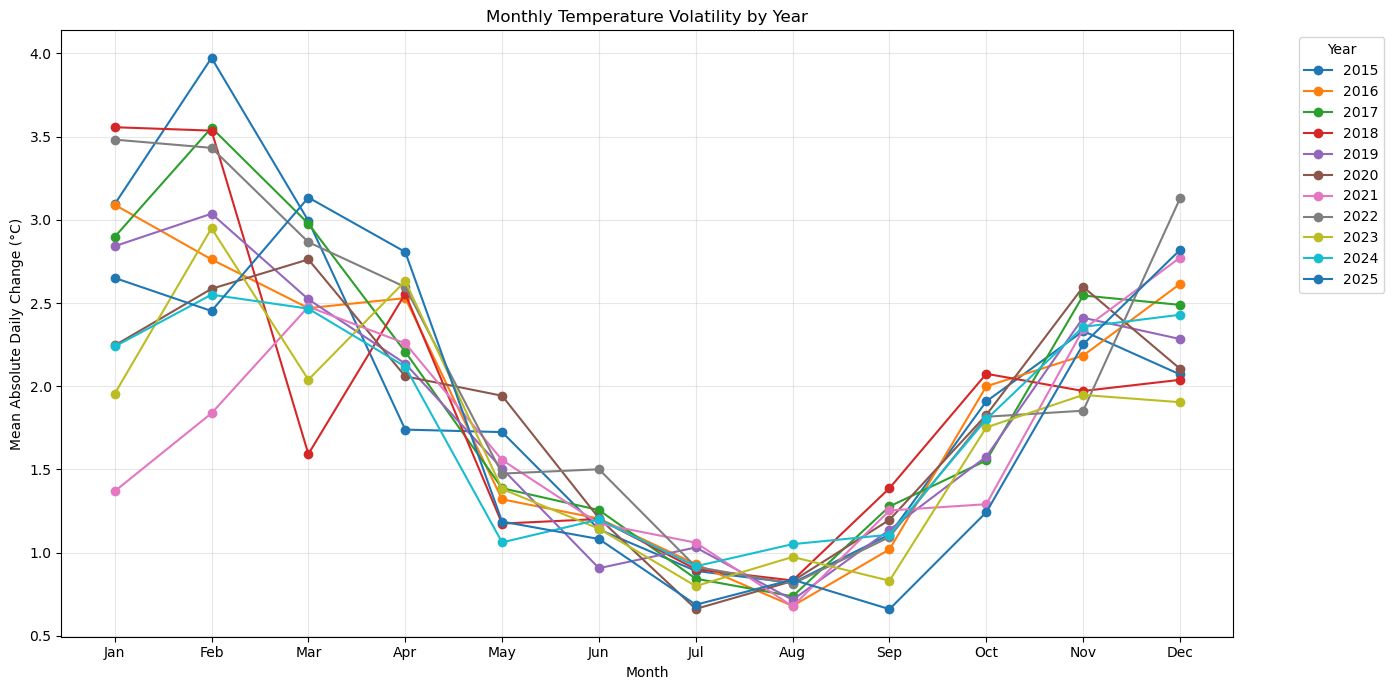

In [5]:
# Calculate mean absolute daily change per month per year
temp['year'] = temp['date'].dt.year
temp['month'] = temp['date'].dt.month
temp['daily_change'] = temp['temp_c'].diff().abs()

monthly_vol = temp.groupby(['year', 'month'])['daily_change'].mean().reset_index()
monthly_vol.columns = ['year', 'month', 'volatility']
vol_pivot = monthly_vol.pivot(index='month', columns='year', values='volatility')

# Line chart: x=month, one colored line per year
fig, ax = plt.subplots(figsize=(14, 7))

for year in sorted(monthly_vol['year'].unique()):
    data = monthly_vol[monthly_vol['year'] == year]
    ax.plot(data['month'], data['volatility'], marker='o', label=str(year))

ax.set_xlabel('Month')
ax.set_ylabel('Mean Absolute Daily Change (°C)')
ax.set_title('Monthly Temperature Volatility by Year')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

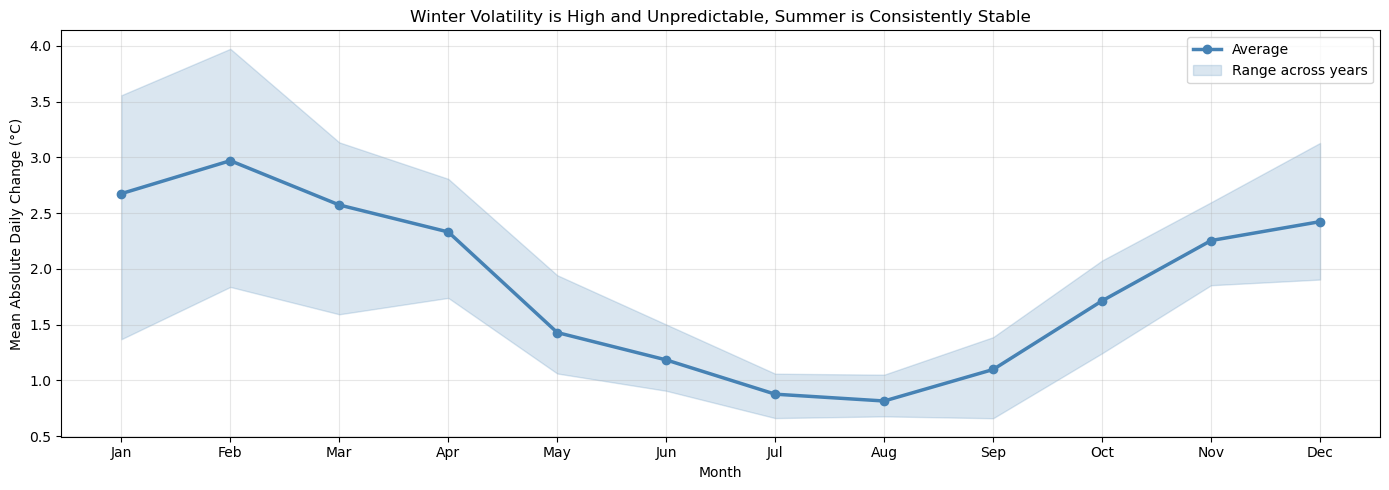

Key insight: Winter months show both higher volatility AND wider year-to-year spread,
meaning not only are temperatures jumpier in winter, but how jumpy they are is itself unpredictable.


In [6]:
# Cleaned up: Average volatility across years with spread
month_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
avg_vol = vol_pivot.mean(axis=1)
min_vol = vol_pivot.min(axis=1)
max_vol = vol_pivot.max(axis=1)

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(range(1, 13), avg_vol, marker='o', color='steelblue', linewidth=2.5, label='Average', zorder=3)
ax.fill_between(range(1, 13), min_vol, max_vol, alpha=0.2, color='steelblue', label='Range across years')

ax.set_xlabel('Month')
ax.set_ylabel('Mean Absolute Daily Change (°C)')
ax.set_title('Winter Volatility is High and Unpredictable, Summer is Consistently Stable')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_labels)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Key insight: Winter months show both higher volatility AND wider year-to-year spread,")
print("meaning not only are temperatures jumpier in winter, but how jumpy they are is itself unpredictable.")

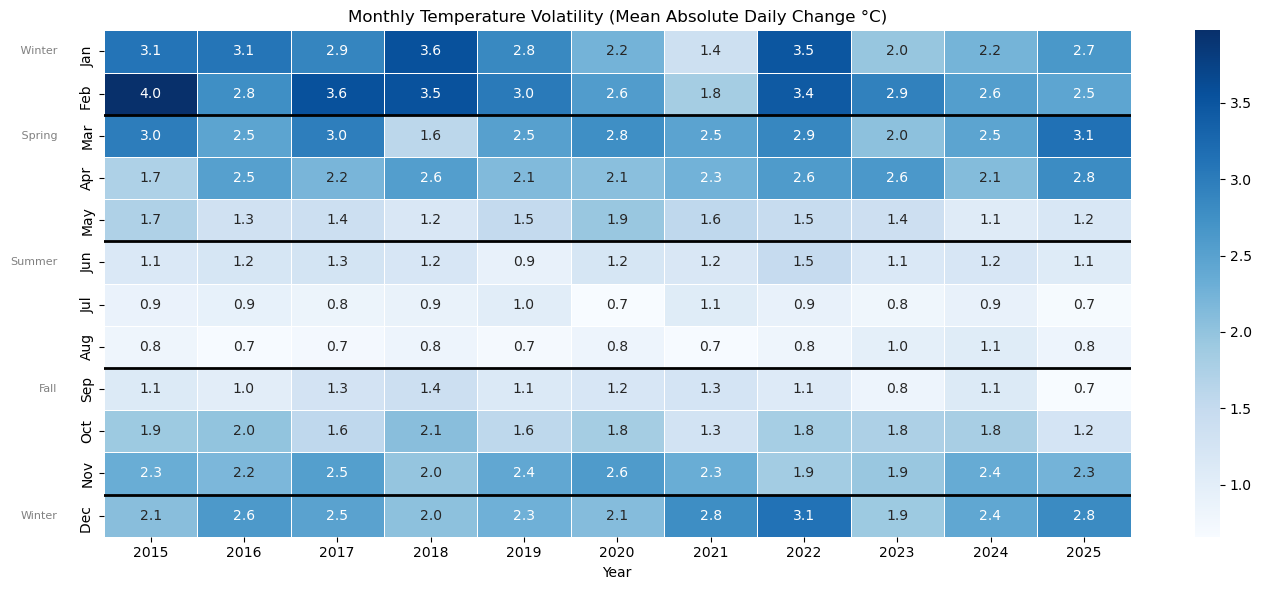

In [7]:
# Heatmap with season dividers
fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(vol_pivot, annot=True, fmt='.1f', cmap='Blues', ax=ax,
            yticklabels=['Jan  ','Feb  ','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec  '],
            linewidths=0.5, linecolor='white')
ax.set_title('Monthly Temperature Volatility (Mean Absolute Daily Change °C)')
ax.set_xlabel('Year')
ax.set_ylabel('')

# Black season dividers
for y in [2, 5, 8, 11]:
    ax.axhline(y=y, color='black', linewidth=2)

# Season labels next to month names
season_labels = {1: ' Winter', 3: ' Spring', 6: 'Summer', 9: 'Fall', 12: 'Winter'}
for month, label in season_labels.items():
    ax.text(-0.5, month - 0.5, label, ha='right', va='center', fontsize=8, color='gray')

plt.tight_layout()
plt.show()

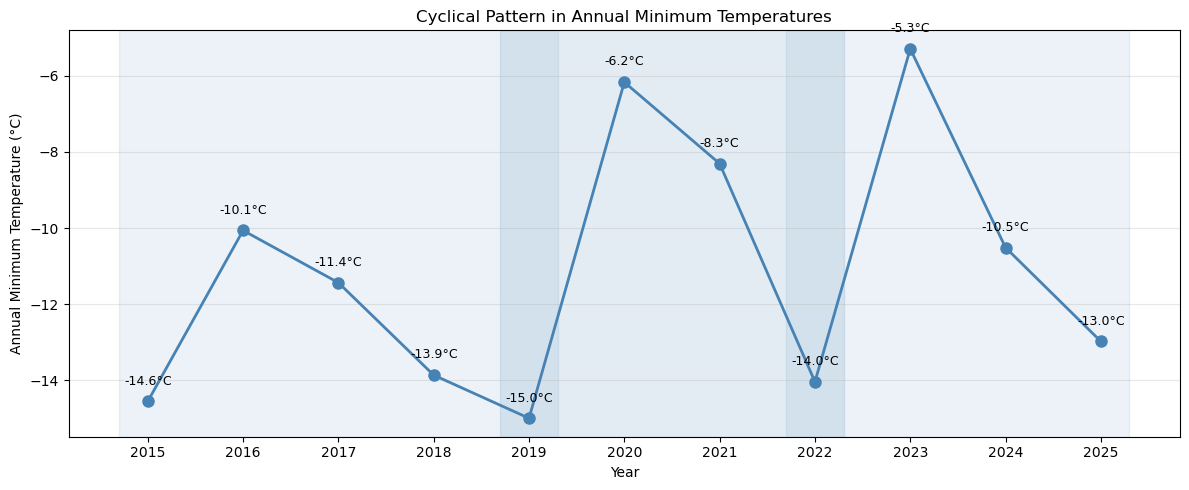

Pattern: After an extreme cold minimum, the following year rebounds warmer,
then gradually drifts colder over 2-3 years before the next rebound.


In [8]:
# Observation: Annual minimum temperature shows a cyclical bounce-back pattern
annual_min = temp.groupby('year')['temp_c'].min()
years = annual_min.index.values
mins = annual_min.values

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(years, mins, marker='o', color='steelblue', linewidth=2, markersize=8, zorder=3)

# Annotate each point
for y, m in zip(years, mins):
    ax.annotate(f'{m:.1f}°C', (y, m), textcoords='offset points', 
                xytext=(0, 12), ha='center', fontsize=9)

# Shade the cycles
cycles = [(2015, 2019, 0.1), (2019, 2022, 0.15), (2022, 2025, 0.1)]
for start, end, alpha in cycles:
    ax.axvspan(start - 0.3, end + 0.3, alpha=alpha, color='steelblue')

ax.set_xlabel('Year')
ax.set_ylabel('Annual Minimum Temperature (°C)')
ax.set_title('Cyclical Pattern in Annual Minimum Temperatures')
ax.set_xticks(years)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("Pattern: After an extreme cold minimum, the following year rebounds warmer,")
print("then gradually drifts colder over 2-3 years before the next rebound.")

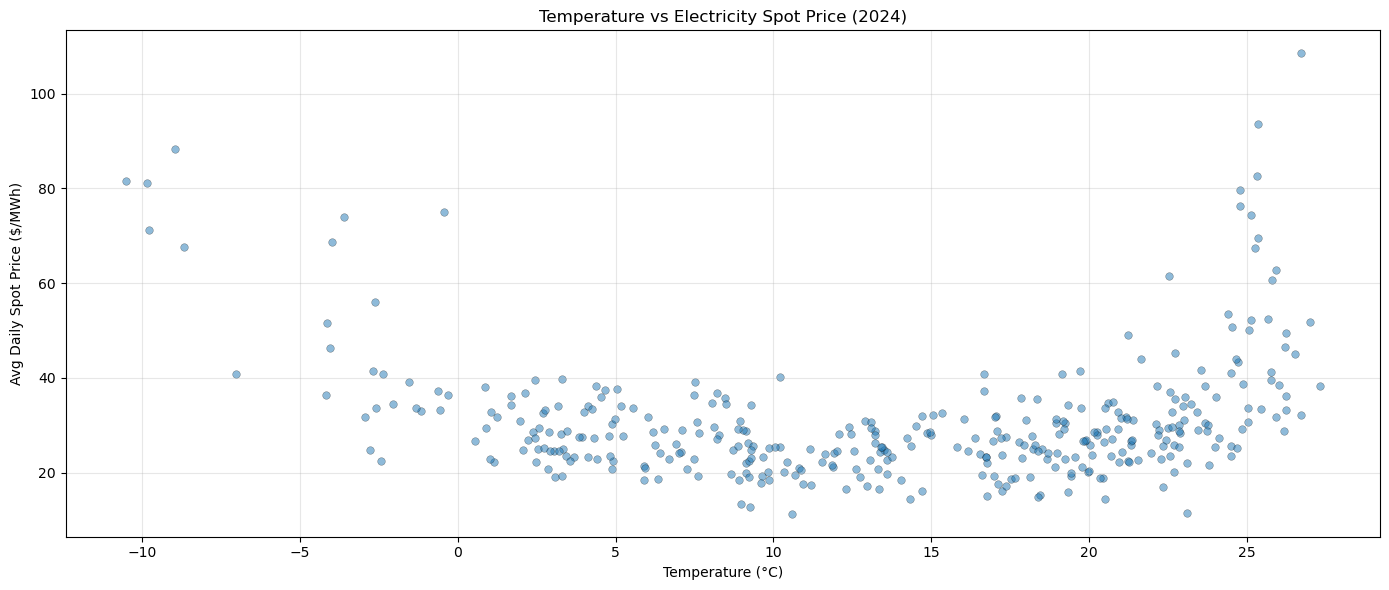

Correlation: -0.004


In [9]:
# Does temperature affect electricity prices?
# Merge 2024 temperature with daily electricity stats
elec['date'] = elec['datetime'].dt.date
elec_daily = elec.groupby('date').agg(
    avg_spot=('spot_price', 'mean'),
    max_spot=('spot_price', 'max'),
    avg_futures=('futures_price', 'mean')
).reset_index()
elec_daily['date'] = pd.to_datetime(elec_daily['date'])

merged = temp[['date', 'temp_c']].merge(elec_daily, on='date')

# Scatter: temperature vs average spot price
fig, ax = plt.subplots(figsize=(14, 6))
ax.scatter(merged['temp_c'], merged['avg_spot'], alpha=0.5, s=30, edgecolor='black', linewidth=0.3)
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Avg Daily Spot Price ($/MWh)')
ax.set_title('Temperature vs Electricity Spot Price (2024)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Correlation: {merged['temp_c'].corr(merged['avg_spot']):.3f}")

/var/folders/hd/gwmpkqn560n80bbj37qxccc80000gn/T/ipykernel_54209/271467656.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = merged.groupby('temp_bin').agg(


,avg_price,max_price,days
temp_bin,,,
"(-15, -10]",81.5,141.8,1
"(-10, -5]",69.8,231.1,5
"(-5, 0]",42.5,112.4,20
"(0, 5]",28.5,68.3,54
"(5, 10]",25.9,56.6,57
"(10, 15]",23.7,57.3,52
"(15, 20]",25.9,64.1,67
"(20, 25]",31.4,92.0,83
"(25, 30]",51.3,166.6,27


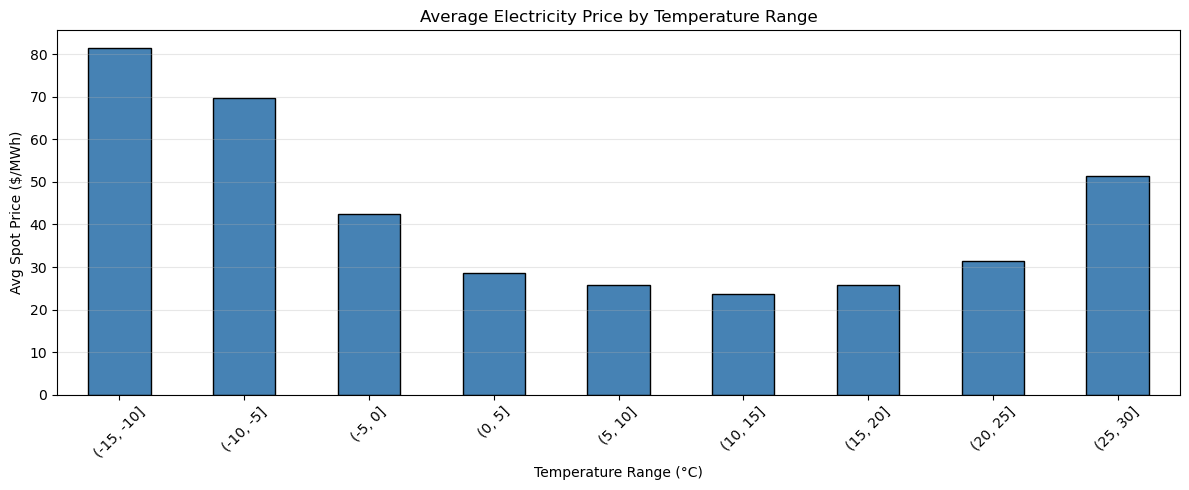

In [10]:
# Bin temperatures and see average price at each range
bins = [-15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
merged['temp_bin'] = pd.cut(merged['temp_c'], bins=bins)

binned = merged.groupby('temp_bin').agg(
    avg_price=('avg_spot', 'mean'),
    max_price=('max_spot', 'mean'),
    days=('avg_spot', 'count')
).round(1)

display(binned)

# Bar chart
fig, ax = plt.subplots(figsize=(12, 5))
binned['avg_price'].plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_xlabel('Temperature Range (°C)')
ax.set_ylabel('Avg Spot Price ($/MWh)')
ax.set_title('Average Electricity Price by Temperature Range')
ax.set_xticklabels([str(x) for x in binned.index], rotation=45)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [11]:
'''
Why 0°C as the "Cold" Threshold?

**1. Electricity prices spike below 0°C.**
Our data shows a clear jump in average spot prices starting in the 0 to -5°C range, with the trend intensifying as temperatures drop further. This is the temperature at which cold starts costing money.

**2. Limited data below 0°C, but a consistent upward trend in prices.**
There are fewer days in the sub-zero range, but every bin shows progressively higher prices. Given that heating demand rises with colder temperatures, assuming this trend continues is reasonable — not a naive assumption.

**3. 0°C is a physical tipping point.**
It's the freezing point of water. Below it, pipes freeze, roads ice over, and infrastructure stress begins. It marks a threshold where measurable, real-world changes occur — not just in energy systems, but across the built environment.

**4. One counterpoint: machines run more efficiently in cold.**
- *Heat dissipation improves* — the larger temperature gap between hot components and cold air accelerates heat transfer (Newton's Law of Cooling).
- *Electrical resistance drops* — metal conductors lose ~0.4% resistance per °C decrease, meaning less energy wasted as heat in wires and components.

However, this efficiency gain is marginal compared to the massive increase in heating demand. Individual machines may perform better, but the grid as a whole is under greater stress.

**Conclusion:** 0°C is a well-supported threshold for defining "cold." It is where electricity prices begin to spike, where physical infrastructure is affected, and where heating demand overtakes any efficiency gains from lower temperatures.


So considering all this I think considering 0 degree as cold would be a sound choice for now unless a stronger reasoning is found for what is defined as cold. 
'''

'\nWhy 0°C as the "Cold" Threshold?\n\n**1. Electricity prices spike below 0°C.**\nOur data shows a clear jump in average spot prices starting in the 0 to -5°C range, with the trend intensifying as temperatures drop further. This is the temperature at which cold starts costing money.\n\n**2. Limited data below 0°C, but a consistent upward trend in prices.**\nThere are fewer days in the sub-zero range, but every bin shows progressively higher prices. Given that heating demand rises with colder temperatures, assuming this trend continues is reasonable — not a naive assumption.\n\n**3. 0°C is a physical tipping point.**\nIt\'s the freezing point of water. Below it, pipes freeze, roads ice over, and infrastructure stress begins. It marks a threshold where measurable, real-world changes occur — not just in energy systems, but across the built environment.\n\n**4. One counterpoint: machines run more efficiently in cold.**\n- *Heat dissipation improves* — the larger temperature gap between ho

In [12]:
# Define cold days and explore their distribution
temp['is_cold'] = temp['temp_c'] < 0

cold_by_year = temp.groupby('year').agg(
    cold_days=('is_cold', 'sum'),
    total_days=('is_cold', 'count')
)
cold_by_year['% cold'] = (cold_by_year['cold_days'] / cold_by_year['total_days'] * 100).round(1)
display(cold_by_year)

# Which months do cold days fall in?
cold_by_month = temp[temp['is_cold']].groupby('month').size()
print("\nCold days by month:")
print(cold_by_month)

print(f"\nTotal cold days: {temp['is_cold'].sum()} out of {len(temp)} ({temp['is_cold'].mean()*100:.1f}%)")

,cold_days,total_days,% cold
year,,,
2015,49,365,13.4
2016,33,366,9.0
2017,30,365,8.2
2018,36,365,9.9
2019,36,365,9.9
2020,18,366,4.9
2021,30,365,8.2
2022,49,365,13.4
2023,12,365,3.3



Cold days by month:
month
1     145
2     104
3      26
11     14
12     80
dtype: int64

Total cold days: 369 out of 4018 (9.2%)


In [18]:
# Deeper look at cold days

# 1. Cold days by month and year — where exactly do they cluster?
cold_month_year = temp[temp['is_cold']].groupby(['year', 'month']).size().unstack(fill_value=0)
print("Cold days by month per year:")
display(cold_month_year)

print("Total cold days per month (across all years):")
print(cold_month_year.sum())

# 2. Do cold days come in streaks or isolated?
winter = temp[temp['month'].isin([1, 2, 3, 11, 12])].copy()
winter['cold_streak'] = (winter['is_cold'] != winter['is_cold'].shift()).cumsum()
streaks = winter[winter['is_cold']].groupby('cold_streak').size()

Cold days by month per year:


month,1,2,3,11,12
year,,,,,
2015,18,23,7,0,1
2016,15,7,1,0,10
2017,6,4,6,1,13
2018,17,8,2,3,6
2019,16,7,5,3,5
2020,5,7,0,0,6
2021,9,20,0,0,1
2022,23,12,3,2,9
2023,4,4,1,2,1


Total cold days per month (across all years):
month
1     145
2     104
3      26
11     14
12     80
dtype: int64


In [36]:
# Feature Engineering
# Predict: will a winter day (Nov-Mar) be below 0°C?
# Constraint: only use data from 6+ months prior

# Ensure day_of_year exists on temp
temp['day_of_year'] = temp['date'].dt.dayofyear

# Filter to winter days only
winter_months = [1, 2, 3, 11, 12]
winter_data = temp[temp['month'].isin(winter_months)].copy()

# --- Feature 1: month ---
# Which month this day falls in. January is historically colder than November,
# so the model can learn seasonal patterns within winter.

# --- Feature 2: day_of_year ---
# Exact position in the calendar (1-365). Captures finer-grained seasonality
# than month alone — e.g., early Jan vs late Jan behave differently.

# --- Feature 3: hist_avg_temp ---
# Average temperature on this exact day of year across ALL prior years.
# Gives the model a historical baseline — "this day is usually around X°C."
# Calculated by looking up the same day_of_year in every year before the current one.

# --- Feature 4: hist_cold_rate ---
# How often this day of year was below 0°C in prior years (0 to 1).
# If Jan 15 was below 0°C in 6 out of 9 prior years, hist_cold_rate = 0.67.
# Directly tells the model "historically, this day has a X% chance of being cold."

# --- Feature 5: prev_winter_cold_days ---
# Total number of cold days in the most recent completed winter (Jan-Mar).
# For Nov-Dec predictions: uses the same year's Jan-Mar.
# For Jan-Mar predictions: uses the previous year's Jan-Mar.
# Captures year-to-year patterns — harsh winters may follow or precede mild ones.

# --- Feature 6: prev_winter_avg_temp ---
# Average temperature of the most recent completed winter (Jan-Mar).
# Same logic as above. Gives an overall sense of how cold the last winter was.

# --- Feature 7: spring_avg_temp ---
# Average temperature during spring (Apr-Jun) before this winter.
# For Nov-Dec: uses same year's spring. For Jan-Mar: uses previous year's spring.
# Tests whether warmer/cooler springs signal anything about the coming winter.
# This is the most recent data we're allowed to use under the 6-month constraint.

# --- Why NaN exists ---
# 2015 is the first year in the dataset. Features that require historical data
# (hist_avg_temp, hist_cold_rate, prev_winter stats, spring_avg_temp) have nothing
# to look back at for 2015, so they produce NaN. This is expected and unavoidable.

hist_avg = {}
hist_cold_rate = {}
for doy in winter_data['day_of_year'].unique():
    for yr in winter_data[winter_data['day_of_year'] == doy]['year'].unique():
        past = temp[(temp['day_of_year'] == doy) & (temp['year'] < yr)]
        hist_avg[(yr, doy)] = past['temp_c'].mean() if len(past) > 0 else np.nan
        hist_cold_rate[(yr, doy)] = (past['temp_c'] < 0).mean() if len(past) > 0 else np.nan

winter_data['hist_avg_temp'] = winter_data.apply(lambda r: hist_avg.get((r['year'], r['day_of_year'])), axis=1)
winter_data['hist_cold_rate'] = winter_data.apply(lambda r: hist_cold_rate.get((r['year'], r['day_of_year'])), axis=1)

winter_stats = temp[temp['month'].isin([1, 2, 3])].groupby('year').agg(
    prev_winter_cold_days=('is_cold', 'sum'),
    prev_winter_avg_temp=('temp_c', 'mean')
)

winter_data['winter_ref_year'] = winter_data['year']
winter_data.loc[winter_data['month'].isin([1, 2, 3]), 'winter_ref_year'] = winter_data['year'] - 1
winter_data = winter_data.merge(winter_stats, left_on='winter_ref_year', right_index=True, how='left')

spring_avg = temp[temp['month'].isin([4, 5, 6])].groupby('year')['temp_c'].mean().rename('spring_avg_temp')
winter_data['spring_ref_year'] = winter_data['year']
winter_data.loc[winter_data['month'].isin([1, 2, 3]), 'spring_ref_year'] = winter_data['year'] - 1
winter_data = winter_data.merge(spring_avg, left_on='spring_ref_year', right_index=True, how='left')


In [24]:
feature_cols = ['month', 'day_of_year', 'hist_avg_temp', 'hist_cold_rate',
                'prev_winter_cold_days', 'prev_winter_avg_temp', 'spring_avg_temp']

# Drop NaN rows (2015 winter days — no historical data to reference)
winter_data = winter_data.dropna(subset=feature_cols)

print(f"Rows remaining: {len(winter_data)}")
print(f"Cold days: {winter_data['is_cold'].sum()} ({winter_data['is_cold'].mean()*100:.1f}%)")
print(f"Year range: {winter_data['year'].min()} to {winter_data['year'].max()}")

Rows remaining: 1512
Cold days: 320 (21.2%)
Year range: 2016 to 2025


In [25]:
# Train/Test Split
# Train: 2016-2024, Test: 2025 (most recent winter, unseen)
train = winter_data[winter_data['year'] < 2025]
test = winter_data[winter_data['year'] == 2025]

X_train = train[feature_cols]
y_train = train['is_cold']
X_test = test[feature_cols]
y_test = test['is_cold']

print(f"Train: {len(X_train)} days ({y_train.sum()} cold, {y_train.mean()*100:.1f}%)")
print(f"Test:  {len(X_test)} days ({y_test.sum()} cold, {y_test.mean()*100:.1f}%)")

# Why Random Forest?
# 1. Works well for binary classification (cold vs not cold)
# 2. Doesn't need feature scaling — our features are on different scales
#    (month: 1-12, day_of_year: 1-365, temperatures: -15 to 30)
# 3. Provides feature importance — tells us which features matter most
# 4. class_weight='balanced' handles our imbalanced data (~21% cold days)

model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(f"\nTest Results:")
print(classification_report(y_test, y_pred, target_names=['Not Cold', 'Cold']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")

Train: 1361 days (270 cold, 19.8%)
Test:  151 days (50 cold, 33.1%)

Test Results:
              precision    recall  f1-score   support

    Not Cold       0.68      0.90      0.78       101
        Cold       0.44      0.16      0.24        50

    accuracy                           0.66       151
   macro avg       0.56      0.53      0.51       151
weighted avg       0.60      0.66      0.60       151

ROC-AUC: 0.709


In [26]:
winter_data.head(10)

,date,temp_c,year,month,daily_change,is_cold,day_of_year,hist_avg_temp,hist_cold_rate,winter_ref_year,prev_winter_cold_days,prev_winter_avg_temp,spring_ref_year,spring_avg_temp
365,2016-01-01,0.958804,2016,1,2.784534,False,1,-2.803516,1.0,2015,48.0,-0.776831,2015,17.758481
366,2016-01-02,0.513901,2016,1,0.444904,False,2,1.178584,0.0,2015,48.0,-0.776831,2015,17.758481
367,2016-01-03,1.293249,2016,1,0.779348,False,3,3.082917,0.0,2015,48.0,-0.776831,2015,17.758481
368,2016-01-04,-1.035242,2016,1,2.328491,True,4,6.598717,0.0,2015,48.0,-0.776831,2015,17.758481
369,2016-01-05,-4.954214,2016,1,3.918971,True,5,-3.825794,1.0,2015,48.0,-0.776831,2015,17.758481
370,2016-01-06,-2.129693,2016,1,2.824521,True,6,-6.339157,1.0,2015,48.0,-0.776831,2015,17.758481
371,2016-01-07,1.765745,2016,1,3.895438,False,7,-8.930278,1.0,2015,48.0,-0.776831,2015,17.758481
372,2016-01-08,4.402484,2016,1,2.636739,False,8,-13.688683,1.0,2015,48.0,-0.776831,2015,17.758481
373,2016-01-09,6.679825,2016,1,2.277341,False,9,-6.393906,1.0,2015,48.0,-0.776831,2015,17.758481
374,2016-01-10,2.594727,2016,1,4.085098,False,10,-10.047647,1.0,2015,48.0,-0.776831,2015,17.758481


In [27]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Logistic Regression needs scaled features (unlike Random Forest)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

lr_pred = lr_model.predict(X_test_scaled)
lr_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression - Test Results:")
print(classification_report(y_test, lr_pred, target_names=['Not Cold', 'Cold']))
print(f"ROC-AUC: {roc_auc_score(y_test, lr_proba):.3f}")

# Compare side by side
print("\n" + "="*40)
print("Model Comparison:")
print(f"  Random Forest  ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(f"  Logistic Reg   ROC-AUC: {roc_auc_score(y_test, lr_proba):.3f}")

Logistic Regression - Test Results:
              precision    recall  f1-score   support

    Not Cold       0.76      0.52      0.62       101
        Cold       0.41      0.66      0.50        50

    accuracy                           0.57       151
   macro avg       0.58      0.59      0.56       151
weighted avg       0.64      0.57      0.58       151

ROC-AUC: 0.684

Model Comparison:
  Random Forest  ROC-AUC: 0.709
  Logistic Reg   ROC-AUC: 0.684


In [28]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

gb_pred = gb_model.predict(X_test)
gb_proba = gb_model.predict_proba(X_test)[:, 1]

print("Gradient Boosting - Test Results:")
print(classification_report(y_test, gb_pred, target_names=['Not Cold', 'Cold']))
print(f"ROC-AUC: {roc_auc_score(y_test, gb_proba):.3f}")

# Final comparison
print("\n" + "="*40)
print("Model Comparison (ROC-AUC):")
print(f"  Random Forest:     {roc_auc_score(y_test, y_proba):.3f}")
print(f"  Logistic Reg:      {roc_auc_score(y_test, lr_proba):.3f}")
print(f"  Gradient Boosting: {roc_auc_score(y_test, gb_proba):.3f}")

Gradient Boosting - Test Results:
              precision    recall  f1-score   support

    Not Cold       0.70      0.99      0.82       101
        Cold       0.89      0.16      0.27        50

    accuracy                           0.72       151
   macro avg       0.80      0.58      0.55       151
weighted avg       0.77      0.72      0.64       151

ROC-AUC: 0.797

Model Comparison (ROC-AUC):
  Random Forest:     0.709
  Logistic Reg:      0.684
  Gradient Boosting: 0.797


In [30]:
# Support Vector Machine
from sklearn.svm import SVC

# SVM needs scaled features
svm_model = SVC(class_weight='balanced', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

svm_pred = svm_model.predict(X_test_scaled)
svm_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

print("SVM - Test Results:")
print(classification_report(y_test, svm_pred, target_names=['Not Cold', 'Cold']))
print(f"ROC-AUC: {roc_auc_score(y_test, svm_proba):.3f}")

# Final comparison
print("\n" + "="*40)
print("Model Comparison (ROC-AUC):")
print(f"  Random Forest:     {roc_auc_score(y_test, y_proba):.3f}")
print(f"  Logistic Reg:      {roc_auc_score(y_test, lr_proba):.3f}")
print(f"  Gradient Boosting: {roc_auc_score(y_test, gb_proba):.3f}")
print(f"  SVM:               {roc_auc_score(y_test, svm_proba):.3f}")

SVM - Test Results:
              precision    recall  f1-score   support

    Not Cold       0.80      0.74      0.77       101
        Cold       0.54      0.62      0.58        50

    accuracy                           0.70       151
   macro avg       0.67      0.68      0.67       151
weighted avg       0.71      0.70      0.71       151

ROC-AUC: 0.785

Model Comparison (ROC-AUC):
  Random Forest:     0.709
  Logistic Reg:      0.684
  Gradient Boosting: 0.797
  SVM:               0.785


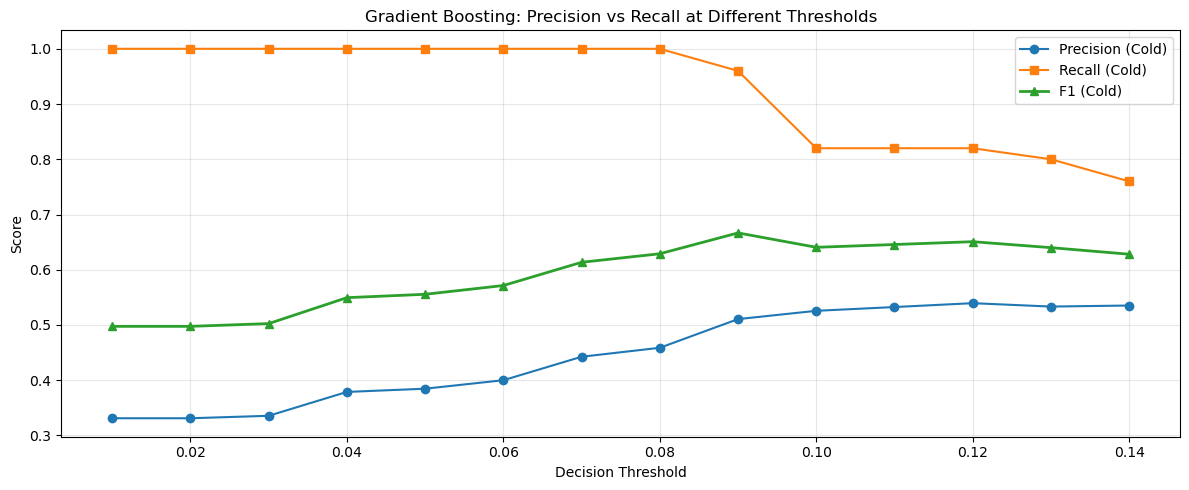

,threshold,precision,recall,f1,accuracy
0,0.01,0.331,1.00,0.498,0.331
1,0.02,0.331,1.00,0.498,0.331
2,0.03,0.336,1.00,0.503,0.344
3,0.04,0.379,1.00,0.549,0.457
4,0.05,0.385,1.00,0.556,0.470
5,0.06,0.400,1.00,0.571,0.503
6,0.07,0.442,1.00,0.613,0.583
7,0.08,0.459,1.00,0.629,0.609
8,0.09,0.511,0.96,0.667,0.682
9,0.10,0.526,0.82,0.641,0.695



Best F1 threshold: 0.09
  Precision: 0.511
  Recall:    0.960
  F1:        0.667


In [33]:
# Threshold tuning for Gradient Boosting
from sklearn.metrics import precision_recall_curve, f1_score

thresholds_to_try = np.arange(0.01, 0.15, 0.01)
results = []

for t in thresholds_to_try:
    preds = (gb_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    results.append({
        'threshold': t,
        'precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'f1': f1_score(y_test, preds),
        'accuracy': (tp + tn) / len(y_test)
    })

res_df = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(res_df['threshold'], res_df['precision'], marker='o', label='Precision (Cold)')
ax.plot(res_df['threshold'], res_df['recall'], marker='s', label='Recall (Cold)')
ax.plot(res_df['threshold'], res_df['f1'], marker='^', label='F1 (Cold)', linewidth=2)
ax.set_xlabel('Decision Threshold')
ax.set_ylabel('Score')
ax.set_title('Gradient Boosting: Precision vs Recall at Different Thresholds')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

display(res_df.round(3))

best_idx = res_df['f1'].idxmax()
best_t = res_df.loc[best_idx, 'threshold']
print(f"\nBest F1 threshold: {best_t:.2f}")
print(f"  Precision: {res_df.loc[best_idx, 'precision']:.3f}")
print(f"  Recall:    {res_df.loc[best_idx, 'recall']:.3f}")
print(f"  F1:        {res_df.loc[best_idx, 'f1']:.3f}")

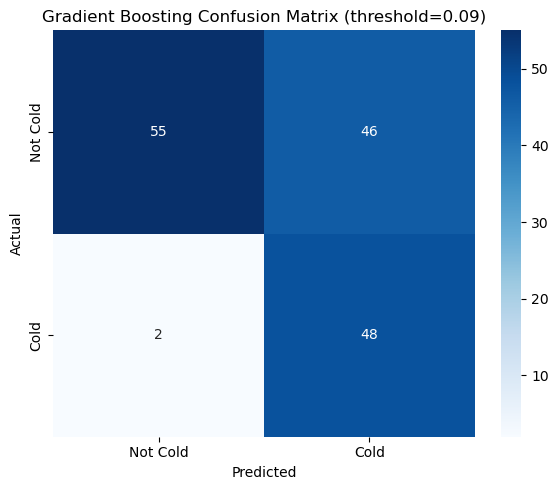

              precision    recall  f1-score   support

    Not Cold       0.96      0.54      0.70       101
        Cold       0.51      0.96      0.67        50

    accuracy                           0.68       151
   macro avg       0.74      0.75      0.68       151
weighted avg       0.81      0.68      0.69       151



In [35]:
# Confusion Matrix: Gradient Boosting at threshold = 0.09
threshold = 0.09
gb_pred_tuned = (gb_proba >= threshold).astype(int)

cm = confusion_matrix(y_test, gb_pred_tuned)

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Not Cold', 'Cold'], yticklabels=['Not Cold', 'Cold'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'Gradient Boosting Confusion Matrix (threshold={threshold})')
plt.tight_layout()
plt.show()

print(classification_report(y_test, gb_pred_tuned, target_names=['Not Cold', 'Cold']))